# Demonstration Notebook
This is a Notebook designed to demonstrate how to use some of the different functions in the code.
It doesn't show everything but shows some of the core features. First we need to import pyNab itself.

First we need to import pyNab itself.
You may see various messages during this import related to features being enabled or disabled. 

In [1]:
import pyNab as Nab

Due to some ongoing work on experimental GPU features, some warning statments may print during import
If you see statements about CUDA or cupy, they should be safe to ignore
If you have any questions feel free to email me: dgma224@g.uky.edu


pyNab has a variety of optional features that are enabled if they are detected on your computer. 
- GPU support through cupy
- FPGA emulation through fxpmath fixed precision library
- Accelerated FFT operations with pyFFTW (or GPU if available)
- Custom HDF5 compression through nabCompression.h5 (soon to be renamed)

## Introduction to pyNab and How it Works

pyNab is built around a series of different modules/classes. 
Each module/class serves a distinct purpose motivated by data in the Nab experiment

- pyNab.py: Defines DataRun Class
    - Loads in all sub-modules to combine all of the data from a single run
    - waveformFileClass.py: pyNab.wf : Defines waveformFile Class
        - .singl, .pulsr, .noise, .coinc
        - Loads in waveform files specifically
        - Uses Dask/Numpy to load in the waveforms themselves
        - Uses Pandas to handle the headers for each waveform
    - temperatureFileClass.py : pyNab.tmf : temperatureFile Class
        - .tmprt
        - Loads in the FPGA temperatures
    - parameterFileClass.py : pyNab.pf : parameterFile Class
        - .param
        - Parses the .param output file from Manitoba data to load in pixel maps and other useful run parameters
        - For ORNL datasets, parses the HDF5 parameter group
    - eventFileClass.py: pyNab.ef : Defines eventFile Class
        - .event
        - Loads in the events as identified by the DAQ. Not particularly useful for Manitoba data due to formatting issues
        - Will be updated with more functionality for ORNL datasets
    - triggerFileClass.py: pyNab.tf : Defines triggerFile Class
        - .trigg
        - This class handles the triggers returned from the FPGAs
        - also implements some basic cutting routines
    - resultFileClass.py : pyNab.rf : resultFile Class
        - Handles the results from certain analysis functions in waveformFileClass
        - Basically wraps around pandas dataframes with some extra functionality thrown in 
            - In particular cutting routines
            - Some basic plotting routines and some other functionality as well
    There are also other files that are responsible for file formatting and data processing.

    - basicFunctions.py : bf
        - It's name is a lie. This is where all the analysis code is defined
    - gpuFunctions.py : pyNab.bf.gpu
        - Where the GPU functions are defined. Currently doesn't have much, work in progress
    - fileFormats.py : pyNab.ff
        - This is where the binary file formats are defined for the structured binary files such as from Manitoba

## Opening a whole Run of Data

The Class DataRun handles opening entire sets of data that were output from the DAQ. The user is expected to pass this class a directory to search for files, and the run number. This code will automatically open ALL files associated with this run that are in the directory. Missing files will cause errors.

In [86]:
runNumber = 1374
directory = 'C:\\Users\\David\\Documents\\datafiles\\pNabDemoData\\'

In [87]:
runWithEvents = Nab.DataRun(directory, runNumber)

You'll probably notice this takes a bit to run. This is normally due to the eventFile Class. This class is very inefficient for the Manitoba dataset because of file format issues. If you want to avoid that, try this instead.

In [6]:
runWithoutEvents = Nab.DataRun(directory, runNumber, ignoreEventFile = True)

Now you have the same set of data, but one of them has the events and the other doesn't.

Note that while these do use some RAM, they don't use nearly as much RAM as the whole file size. This is because of the use of Dask to handle the waveform files. These files are only loaded when you specifically request that data to be processed, saving memory and allowing you to handle very large amounts of data easily. 

In [88]:
runWithEvents = None
runWithoutEvents = None

## Getting information from the files

Plenty of information is available through the class itself

In [2]:
runNumber = 1375
directory = 'G:\\Shared drives\\Nab\\Manitoba Tests\\Manitoba Data\\01-26-2022 Sn113 Partial Bias Scan + 3hr -300V Bias Run\\'
run = Nab.DataRun(directory, runNumber, ignoreEventFile = True)

In [3]:
print('There are ', run.singleWaves().numWaves, ' singles waveforms, each is ', run.singleWaves().wavelength, ' long')
print('There are ', run.coincWaves().numWaves, ' coincidence waveforms, each is ', run.coincWaves().wavelength, ' long')
print('There are ', run.pulsrWaves().numWaves, ' pulser waveforms, each is ', run.pulsrWaves().wavelength, ' long')
print('There are ', run.noiseWaves().numWaves, ' noise waveforms, each is ', run.noiseWaves().wavelength, ' long')
print('There are ', run.triggers().numtrigs, ' triggers')

There are  127867  singles waveforms, each is  7000  long
There are  0  coincidence waveforms, each is  0  long
There are  386624  pulser waveforms, each is  7000  long
There are  6496  noise waveforms, each is  32767  long
There are  183762  triggers


Metadata such as the filter parameters is available through the parameters class.

In [10]:
parameters = run.parameterFile()
print(parameters.FilterParameters.dtype)
print(parameters.FilterParameters)

[('board', '<i4'), ('channel', '<i4'), ('threshold', '<i4'), ('DecayParameter', '<i4'), ('TrapFlatTop', '<i4'), ('TrapRiseTime', '<i4')]
[( 0, 0,         20, 625, 10, 625) ( 0, 1,         20, 625, 10, 625)
 ( 0, 2,         20, 625, 10, 625) ( 0, 3,         20, 625, 10, 625)
 ( 0, 4,         20, 625, 10, 625) ( 0, 5,         20, 625, 10, 625)
 ( 0, 6,         20, 625, 10, 625) ( 0, 7,         20, 625, 10, 625)
 ( 1, 0,         20, 625, 10, 625) ( 1, 1,         20, 625, 10, 625)
 ( 1, 2,         20, 625, 10, 625) ( 1, 3,         20, 625, 10, 625)
 ( 1, 4,         20, 625, 10, 625) ( 1, 5,         20, 625, 10, 625)
 ( 1, 6,         20, 625, 10, 625) ( 1, 7,    1000000, 625, 10, 625)
 ( 2, 0,    1000000, 625, 10, 625) ( 2, 1,         20, 625, 10, 625)
 ( 2, 2,         20, 625, 10, 625) ( 2, 3,         20, 625, 10, 625)
 ( 2, 4,         20, 625, 10, 625) ( 2, 5,         20, 625, 10, 625)
 ( 2, 6,         20, 625, 10, 625) ( 2, 7,   10000000, 625, 10, 625)
 ( 3, 0,         20, 625, 10, 625) 

Also information such as how the coincidence logic was configured is available

In [50]:
parameters.BoardChannelPixelMap

array([(  0,  90), (  1, 110), (  2, 111), (  3, 120), (  4, 127),
       (  5, 119), (  6,  89), (  7,  99), (  8, 108), (  9, 126),
       ( 10, 117), ( 11, 125), ( 12,  98), ( 13, 115), ( 14, 123),
       ( 15, 109), ( 16, 118), ( 17,  76), ( 18, 124), ( 19,  97),
       ( 20,  88), ( 21, 107), ( 22, 122), ( 23, 116), ( 24, 121),
       ( 25,  96), ( 26, 105), ( 27,  87), ( 28, 113), ( 29,  95),
       ( 30, 104), ( 31, 114), ( 32,  75), ( 33, 106), ( 34,  74),
       ( 35,  84), ( 36,  86), ( 37,  85), ( 38,  71), ( 39,  83),
       ( 40,  94), ( 41,  61), ( 42,  72), ( 43,  64), ( 44,  62),
       ( 45,  73), ( 46,  60), ( 47,  63), ( 48,  48), ( 49,  46),
       ( 50,  58), ( 51,  49), ( 52,  38), ( 53,  35), ( 54,  59),
       ( 55,  47), ( 56,  50), ( 57,  25), ( 58,  26), ( 59,  28),
       ( 60,  51), ( 61,  16), ( 62,  37), ( 63,  36), ( 64,  27),
       ( 65,  18), ( 66,  17), ( 67,   1), ( 68,   9), ( 69,   8),
       ( 70,  19), ( 71,  20), ( 72,  11), ( 73,   3), ( 74,  

If you want to access the raw original data for the classes, this can be done via a few helper functions.

For waveform files, the following functions are what you'll want to use

In [29]:
run.singleWaves().headers()

,result,eventid,bc,timestamp,req,source,length,board,channel,pixel
0,1,0,12,3751522,9470076,0,7000,1,4,98
1,1,0,27,3751522,9473622,1,7000,3,3,87
2,1,0,20,3751522,9476996,1,7000,2,4,88
3,1,0,19,3751522,9502154,1,7000,2,3,97
4,1,0,7,3751522,9483322,1,7000,0,7,99
...,...,...,...,...,...,...,...,...,...,...
51677,1,9985,106,172443494760,172451922628,1,7000,13,2,78
51678,1,9985,20,172443494760,172451929442,1,7000,2,4,88
51679,1,9985,6,172443494760,172451914060,1,7000,0,6,89
51680,1,9986,109,172487328906,172495694750,0,7000,13,5,103


In [30]:
run.singleWaves().waves()

dask.array<astype, shape=(51682, 7000), dtype=float32, chunksize=(1024, 7000), chunktype=numpy.ndarray>

In [36]:
run.singleWaves().waves()[0].compute()

array([-93., -92., -85., ..., -54., -44., -41.], dtype=float32)

Notice the different return types. 

.headers() returns the headers as a Pandas DataFrame

.waves() returns the waveforms as a Dask Array. This is synonomous with a Numpy array. If you want a Numpy array instead, simply add .compute()

run.singleWaves().waves().compute()

That will load the waveform data into RAM so hopefully you have enough memory. 

If you aren't sure what is available to you, try the following:
    Let tab completion tell you what is available.
Then if you find what you're looking for, use the question mark function to see what it does. 

In [12]:
run.pulsrWaves().

SyntaxError: invalid syntax (Temp/ipykernel_3704/1082497932.py, line 1)

In [15]:
run.singleWaves().headers?

Object `headers` not found.


In [ ]:
run.singleWaves().headers

Note that for this you NEED to go to the original class structure. So for pulsrWaves(), this object is a waveform file. So you have to do Nab.wf.waveformFile.BLAHBLAH
and then replace BLAHBLAH with the function of interest.

In [17]:
Nab.wf.waveformFile.headers?

Signature: Nab.wf.waveformFile.headers(self, orig=False)
Docstring:
Returns the waveform headers as a Pandas DataFrame.

Parameters
----------
orig: bool
        If orig is true, return the whole original DataFrame without cuts
        If orig is false, return the DataFrame with cuts

Returns
-------
headers: Pandas DataFrame
File:      c:\users\david\documents\datafilereadingscripts\waveformfileclass.py
Type:      function


The difference is pretty obvious. Otherwise these are identical. If you don't plan on using the event information, I'd recommend using the ignoreEventFile flag.

If you want to see what boards and channels were recorded in a waveform file, along with how many times they were recorded, you can do that with the following command. The mapping variable tells you what board and channel each waveform was in the order they occured. 

In [40]:
bcs = run.singleWaves().bcs
print('board channels', bcs[0])
print('mapping', bcs[1])
print('counts', bcs[2])

bcs = run.triggers().bcs
print('board channels', bcs[0])
print('mapping', bcs[1])
print('counts', bcs[2])

board channels [0, 1, 2, 6, 7, 8, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 51, 99, 100, 102, 104, 105, 106, 108, 109, 111]
mapping [ 8 21 14 ...  3 50 45]
counts [1299  687  687 1595 1013  866  294  294 2385 1472  992 2446  523 2544
 3020 1726 1149 1097  838 1325 1429 2796  893  916  607 1620 1463 1958
  164  334 1420  674  169  334  164  169 1247  164  333  164  703  164
  164  612  612  664  687 2298 1156  687  664    1]
board channels [12, 13, 14, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 31, 33, 35, 41, 105, 106, 108, 109, 111]
mapping [ 0  0  0 ...  5 21 22]
counts [50168 45593 45449 52237 45926 46376 48428 45883 44660 44683 46317 45475
 53553 44853 44016 44846 45368 44056 43971 50110 50673 52437 51458 20751]


If you want to see the mapping between board/channel to pixel, that can be found in the parameter file. The first number is the board * 8 + channel number and the second is the pixel number in each element in the list

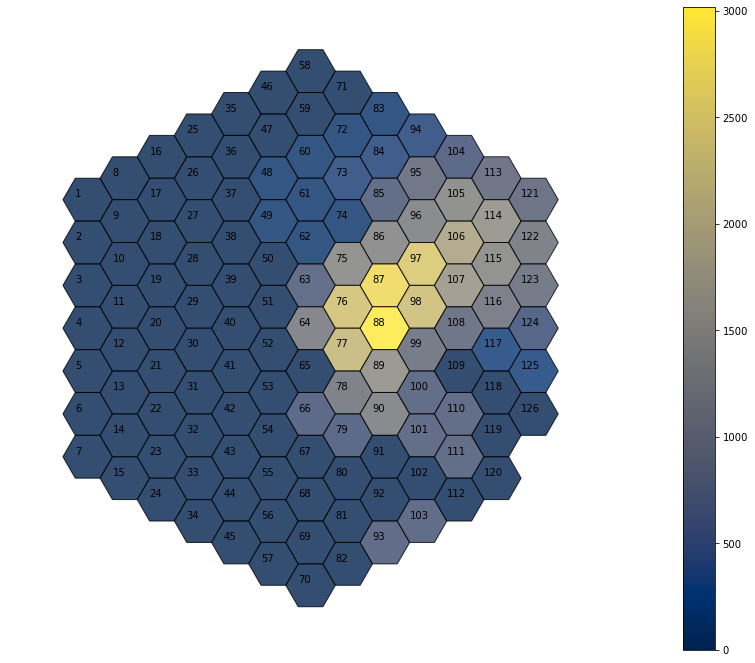

In [51]:
run.plotHitLocations(sourceFile = 'singles', cmap = 'cividis', showNum=True, showVal = True, alpha=0.8, rounding=1, size=1.3)

## Analysis Functionality

### Applying Data Cuts and Energy Extraction

When you want to run analysis, it's often desirable to only look at part of the data file. That way you don't spend as much time running possibly complicated analysis over data you aren't interested in. 

Based on the pixel map above, it looks like pixel 87 has some data we might want so let's look at that.

In [4]:
run.singleWaves().resetCuts()
run.singleWaves().defineCut('pixel', '=', 88)
headers = run.singleWaves().headers()
print(headers)

        result  eventid  bc     timestamp           req  source  length  \
9            1        3  20      57882948      63519760       0    7000   
54           1        9  20      97777604     103532194       1    7000   
59           1       10  20     108230464     114089244       1    7000   
64           1       11  20     115011904     120535604       1    7000   
73           1       12  20     117755646     123303162       1    7000   
...        ...      ...  ..           ...           ...     ...     ...   
127769       1    24988  20  434950530236  434962885278       1    7000   
127810       1    24998  20  435138266264  435149466092       1    7000   
127818       1    25001  20  435288021924  435299728634       0    7000   
127842       1    25005  20  435312141840  435323236820       1    7000   
127857       1    25010  20  435579609740  435590817276       1    7000   

        board  channel  pixel  
9           2        4     88  
54          2        4     88  
59 

Now when you use either the .headers() or the .waves() functions, they will only return data that passes the cuts applied. Note that we can apply multiple cuts by simply using defineCut again. It's always recommended to use resetCuts() whenever you enter a new cell as the waveformFile object will remember the previous cuts applied until you reset them. 

Any parameter in the header information can be cut on. The cut functionality can be found below.

In [55]:
Nab.bf.defineCut?

Signature: Nab.bf.defineCut(data, category, operator=None, optionA=None, optionB=None)
Docstring:
This function defines a cut to apply to the dataset. 
You can only cut on data available in the headers

Parameters
----------
data: dask.DataFrame
        the DataFrame that contains the dataset
category : str
        the category to cut on. Must be a category in the waveform header
        To check available categories, call yourWaveformFile.headerType
        Also available categories:
                'pixel': requires a pixel map to be defined in the class
                'custom': unique operation that allows the user to pass a custom map of 
                        the data to request instead of determining the map within the class
                        This changes the behavior of operator
                'ca45Corruption': cut that is based on the conditions Noah described in his thesis.
                        This removes the corruption issues from that version of the DAQ.
     

With this subset applied, we can look at the energy histogram for this pixel. 

Depending on your PC, this may take a while to complete. For large datasets this can be particularly taxing. The code is designed to use ALL of your CPU resources and will run in parallel by default.

In [5]:
results = run.singleWaves().determineEnergyTiming(method='trap', params=[1250, 50, 1250])

Now we can plot this data and see what is there

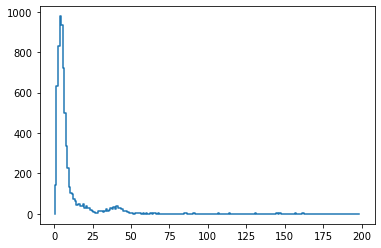

In [6]:
results.hist('energy', bins = Nab.np.arange(0, 200))
results.show()

Not too much for this dataset unfortunately. Mostly just noise.

Note that the bins parameter expects a Numpy array defining the bin edges to be passed in. 

Most of the plotting functionality built into the resultFile class is just calling matplotlib.pyplot behind the scenes. For more plotting funcitonality, I'd recommend just parsing the results object itself.

If you want to get fancy with it, we can do additional cuts to this. Let's look at a high amplitude waveform

In [76]:
results.resetCuts()
results.defineCut('energy', '>', 100)

In [77]:
results.data()

,result,eventid,bc,timestamp,req,source,length,board,channel,pixel,energy,t0
358,1,68,20,1260057960,1265807820,0,7000,2,4,88,221.382965,3508.5
616,1,122,20,2461316868,2467132056,0,7000,2,4,88,2467.415527,3502.0
674,1,131,20,2461318724,2467433714,1,7000,2,4,88,1756.840088,1647.0
679,1,132,20,2461318730,2467484056,1,7000,2,4,88,1755.792236,1640.5
721,1,139,20,2461320416,2467810908,1,7000,2,4,88,1107.697510,-117.0
...,...,...,...,...,...,...,...,...,...,...,...,...
50103,1,9686,20,167601753288,167610338302,0,7000,2,4,88,378.331085,3500.0
50242,1,9713,20,167953157244,167961337636,0,7000,2,4,88,182.871323,3505.0
50454,1,9751,20,168671461122,168679804600,0,7000,2,4,88,165.542267,3500.5
50885,1,9836,20,170126218256,170134592764,0,7000,2,4,88,602.257019,3501.0


Now my results class has the indices saved of the waveforms in the file that satisfy BOTH the original pixel 88 cut AND the energy > 100 cut.

To look at waveforms above that energy range, do this.

In [69]:
run.singleWaves().defineCut('custom', results.returnCut())

waves = run.singleWaves().waves()

Now the only waves in that waves container are large amplitude waveforms

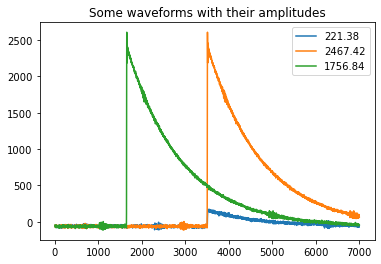

In [70]:
for i in range(3):
	Nab.plt.plot(waves[i], label=str(round(results.data()['energy'].iloc[i], 2)))
Nab.plt.title('Some waveforms with their amplitudes')
Nab.plt.legend()
Nab.plt.show()

In [72]:
run.singleWaves().resetCuts()
run.singleWaves().defineCut('pixel', '=', 88)
headers = run.singleWaves().headers()
print(headers)

       result  eventid  bc     timestamp           req  source  length  board  \
2           1        0  20       3751522       9476996       1    7000      2   
9           1        1  20      15277460      20981650       1    7000      2   
16          1        2  20      45348982      50966840       1    7000      2   
32          1        5  20      81463794      88313938       1    7000      2   
37          1        6  20     106967042     112723642       1    7000      2   
...       ...      ...  ..           ...           ...     ...     ...    ...   
51567       1     9961  20  172093048668  172101622570       1    7000      2   
51586       1     9965  20  172207360858  172214274928       1    7000      2   
51667       1     9983  20  172411477366  172419726904       1    7000      2   
51672       1     9984  20  172416860720  172425173262       1    7000      2   
51678       1     9985  20  172443494760  172451929442       1    7000      2   

       channel  pixel  
2  

### Noise Analysis

Let's look at that same pixel and get a sense of what the noise was like

In [78]:
run.noiseWaves().resetCuts()
run.noiseWaves().defineCut('pixel', '=', 88)

spectra = run.noiseWaves().generatePowerSpectra()

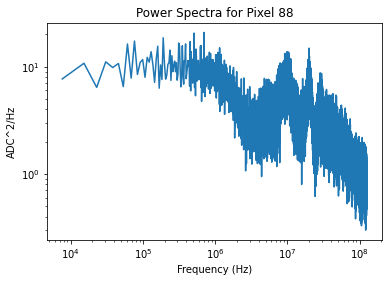

In [79]:
Nab.plt.plot(spectra[0][1:], spectra[1][1:])
Nab.plt.yscale('log')
Nab.plt.xscale('log')
Nab.plt.xlabel('Frequency (Hz)')
Nab.plt.ylabel('ADC^2/Hz')
Nab.plt.title('Power Spectra for Pixel 88')
Nab.plt.show()

Note that the first bin was removed. The first bin is the 0th frequency bin. This bin is often a very small number and can mess with the automatic scaling of the plot so I tend to remove it to make plots simpler. It's not that the data isn't important, just the plots don't look nice easily with it included.

In [80]:
waves = run.singleWaves().waves()